# Wstępna obróbka danych


In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from IPython.display import Image
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [11]:
# Wczytanie danych
data_csv = pd.read_csv('stroke.csv', sep=';')
data_csv.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Przygotowanie danych do pracy

In [12]:
# Usunięcie wierszy z brakującymi danymi w kolumnie bmi
data_csv = data_csv.dropna(subset=['bmi'])
# Zamiana Yes na 1 oraz No na 0 w kolumnie ever_married
data_csv['ever_married'] = data_csv['ever_married'].map({'Yes': 1, 'No': 0})
# Zastosowanie dummy encoding dla zmiennych kategorycznych
categorical_columns = ['gender', 'work_type', 'Residence_type', 'smoking_status']
data_csv = pd.get_dummies(data_csv, columns=categorical_columns)
data_csv.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,1,228.69,36.6,1,0,1,0,0,1,0,0,0,1,0,1,0,0
2,80.0,0,1,1,105.92,32.5,1,0,1,0,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,1,171.23,34.4,1,1,0,0,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,1,174.12,24.0,1,1,0,0,0,0,1,0,1,0,0,0,1,0
5,81.0,0,0,1,186.21,29.0,1,0,1,0,0,1,0,0,0,1,0,1,0,0


In [13]:
print(data_csv['stroke'].value_counts())

0    4699
1     209
Name: stroke, dtype: int64


Jak widzimy w naszych danych mamy jedynie 209 przypadków osób chorych, natomiast aż 4699 przypadków osób zdrowych. Może to spowodować błędne oszacowanie modelu, gdyż model nauczy się, że prawie zawsze pacjent jest chory. Aby uniknąć takiego przypadku można usunąć niektóre wyniki

In [14]:
data_csv.drop(data_csv[data_csv.stroke == 0].index[-4450:], inplace=True)
print(data_csv['stroke'].value_counts())


0    249
1    209
Name: stroke, dtype: int64


# Zadanie 1

In [15]:
data_rf = data_csv.copy()

# Podział danych na cechy (X) i zmienną wynikową (y)
X = data_rf.drop('stroke', axis=1)
y = data_rf['stroke']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parametry do przetestowania
n_estimators_values = [10, 50, 70, 100, 150, 200]  # różne liczby drzew w lesie
max_features_values = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]  # różna liczba zmiennych w podziale

best_accuracy = 0
best_sensitivity = 0
best_params = {}

# Tworzenie siatki wyników
sensitivity_grid = np.zeros((len(n_estimators_values), len(max_features_values)))

for i, n_estimators in enumerate(n_estimators_values):
    for j, max_features in enumerate(max_features_values):
        rf_model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, random_state=42)
        rf_model.fit(X_train, y_train)
        y_pred_rf = rf_model.predict(X_test)

        true_positive = np.sum((y_test == 1) & (y_pred_rf == 1))
        false_negative = np.sum((y_test == 1) & (y_pred_rf == 0))

        sensitivity = true_positive / (true_positive + false_negative)
        sensitivity_grid[i][j] = sensitivity

        accuracy = accuracy_score(y_test, y_pred_rf)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
        if sensitivity > best_sensitivity:
            best_sensitivity = sensitivity
            best_params = {"n_estimators": n_estimators, "max_features": max_features}

# Tworzenie siatki wyników
sensitivity_grid = np.zeros((len(n_estimators_values), len(max_features_values)))
accuracy_grid = np.zeros((len(n_estimators_values), len(max_features_values)))

for i, n_estimators in enumerate(n_estimators_values):
    for j, max_features in enumerate(max_features_values):
        rf_model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, random_state=42)
        rf_model.fit(X_train, y_train)
        y_pred_rf = rf_model.predict(X_test)

        true_positive = np.sum((y_test == 1) & (y_pred_rf == 1))
        false_negative = np.sum((y_test == 1) & (y_pred_rf == 0))

        sensitivity = true_positive / (true_positive + false_negative)
        sensitivity_grid[i][j] = sensitivity

        accuracy = accuracy_score(y_test, y_pred_rf)
        accuracy_grid[i][j] = accuracy

        if accuracy > best_accuracy:
            best_accuracy = accuracy

        if sensitivity > best_sensitivity:
            best_sensitivity = sensitivity
            best_params = {"n_estimators": n_estimators, "max_features": max_features}

# Wypisanie najlepszych parametrów i wyników
print("Najlepsze parametry:")
print(best_params)
print(f"Najlepsza czułość: {best_sensitivity}")
print(f"Najlepsza dokładność: {best_accuracy}")
print(f"Najlepsza liczba drzew: {best_params['n_estimators']}")
print(f"Najlepsza liczba zmiennych: {best_params['max_features']}")


Najlepsze parametry:
{'n_estimators': 100, 'max_features': 5}
Najlepsza czułość: 0.8
Najlepsza dokładność: 0.7608695652173914
Najlepsza liczba drzew: 100
Najlepsza liczba zmiennych: 5


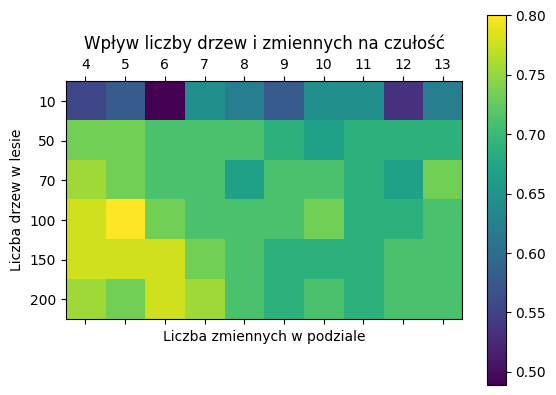

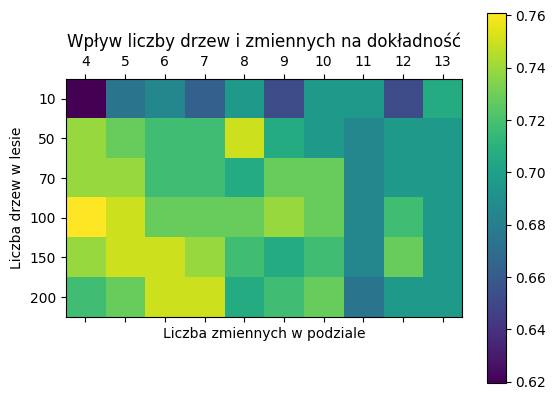

In [16]:
# Wyświetlenie wykresu czułości
fig, ax1 = plt.subplots()
cax1 = ax1.matshow(sensitivity_grid, cmap='viridis')
fig.colorbar(cax1)
ax1.set_xticks(np.arange(len(max_features_values)))
ax1.set_yticks(np.arange(len(n_estimators_values)))
ax1.set_xticklabels(max_features_values)
ax1.set_yticklabels(n_estimators_values)
plt.xlabel('Liczba zmiennych w podziale')
plt.ylabel('Liczba drzew w lesie')
plt.title('Wpływ liczby drzew i zmiennych na czułość')

# Wyświetlenie wykresu dokładności
fig, ax2 = plt.subplots()
cax2 = ax2.matshow(accuracy_grid, cmap='viridis')
fig.colorbar(cax2)
ax2.set_xticks(np.arange(len(max_features_values)))
ax2.set_yticks(np.arange(len(n_estimators_values)))
ax2.set_xticklabels(max_features_values)
ax2.set_yticklabels(n_estimators_values)
plt.xlabel('Liczba zmiennych w podziale')
plt.ylabel('Liczba drzew w lesie')
plt.title('Wpływ liczby drzew i zmiennych na dokładność')

plt.show()

In [17]:
# Ważnośc zmiennych w modelu
feature_importances = rf_model.feature_importances_
feature_names = X.columns

# Tworzenie ramki danych z ważnościami zmiennych
importance_df = pd.DataFrame({'Zmienna': feature_names, 'Ważność': feature_importances})
importance_df = importance_df.sort_values(by='Ważność', ascending=False)

# Wyświetlenie wyników
print("Ważność zmiennych w modelu:")
print(importance_df)

Ważność zmiennych w modelu:
                           Zmienna   Ważność
0                              age  0.436661
4                avg_glucose_level  0.186016
5                              bmi  0.144750
1                     hypertension  0.028576
2                    heart_disease  0.022500
3                     ever_married  0.020777
15          smoking_status_Unknown  0.018381
11         work_type_Self-employed  0.018162
17     smoking_status_never smoked  0.016548
16  smoking_status_formerly smoked  0.014996
18           smoking_status_smokes  0.014461
14            Residence_type_Urban  0.013627
13            Residence_type_Rural  0.013617
6                    gender_Female  0.013527
10               work_type_Private  0.012981
8               work_type_Govt_job  0.012267
7                      gender_Male  0.011431
12              work_type_children  0.000721
9           work_type_Never_worked  0.000000


## Zadanie 2


Najlepsze parametry (według dokładności):
{'n_estimators': 50, 'learning_rate': 1.0}
Najlepsza dokładność: 0.7934782608695652
Najlepsza liczba estymatorów: 50
Najlepszy learning rate: 1.0
Najlepsza czułość: 0.9777777777777777


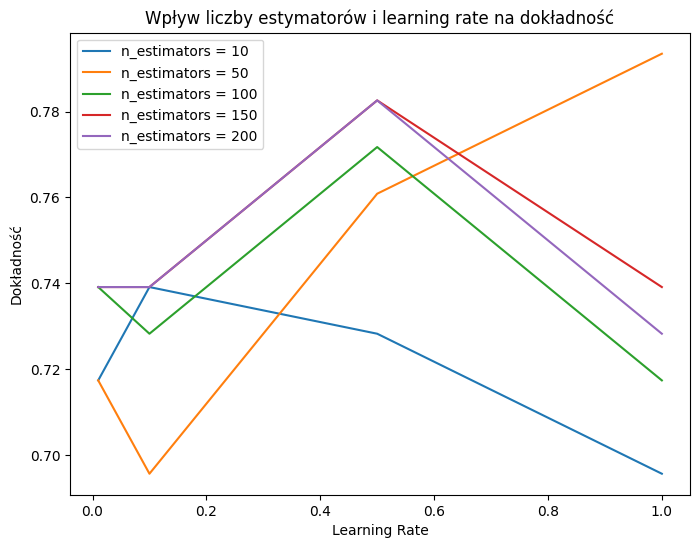

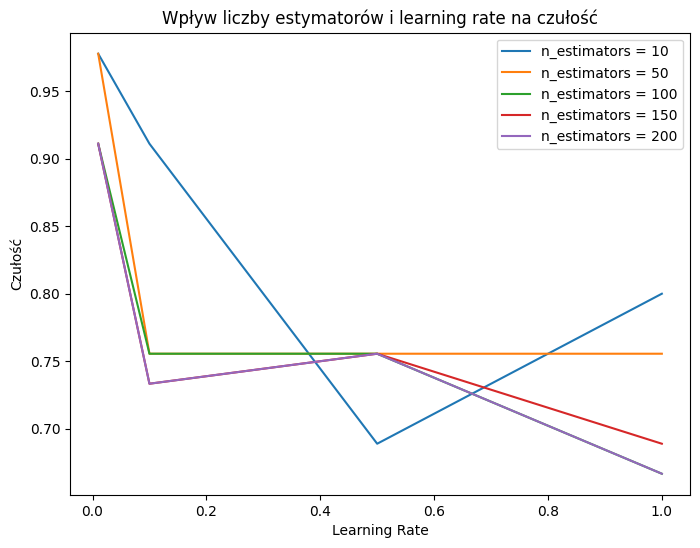

Ważność zmiennych w modelu:
                           Zmienna  Ważność
4                avg_glucose_level    0.395
5                              bmi    0.330
0                              age    0.220
2                    heart_disease    0.015
15          smoking_status_Unknown    0.010
1                     hypertension    0.005
13            Residence_type_Rural    0.005
12              work_type_children    0.005
11         work_type_Self-employed    0.005
18           smoking_status_smokes    0.005
6                    gender_Female    0.005
10               work_type_Private    0.000
8               work_type_Govt_job    0.000
7                      gender_Male    0.000
14            Residence_type_Urban    0.000
3                     ever_married    0.000
16  smoking_status_formerly smoked    0.000
17     smoking_status_never smoked    0.000
9           work_type_Never_worked    0.000


In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parametry do przetestowania
n_estimators_values = [10, 50, 100, 150, 200]  # różne liczby estymatorów w AdaBoost
learning_rate_values = [0.01, 0.1, 0.5, 1.0]  # różne wartości learning rate

best_accuracy = 0
best_params = {}
best_recall = 0


accuracy_grid = np.zeros((len(n_estimators_values), len(learning_rate_values)))
recall_grid = np.zeros((len(n_estimators_values), len(learning_rate_values)))

for i, n_estimators in enumerate(n_estimators_values):
    for j, learning_rate in enumerate(learning_rate_values):
        # Inicjalizacja klasyfikatora AdaBoost z aktualnymi parametrami
        ada_model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
        ada_model.fit(X_train, y_train)
        y_pred_ada = ada_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred_ada)
        recall = recall_score(y_test, y_pred_ada)

        accuracy_grid[i][j] = accuracy
        recall_grid[i][j] = recall

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {"n_estimators": n_estimators, "learning_rate": learning_rate}

        if recall > best_recall:
            best_recall = recall

# Wypisanie najlepszych parametrów i wyników
print("Najlepsze parametry (według dokładności):")
print(best_params)
print(f"Najlepsza dokładność: {best_accuracy}")
print(f"Najlepsza liczba estymatorów: {best_params['n_estimators']}")
print(f"Najlepszy learning rate: {best_params['learning_rate']}")

print(f"Najlepsza czułość: {best_recall}")

# Wyświetlenie wykresu dokładności
plt.figure(figsize=(8, 6))
for i, n_estimators in enumerate(n_estimators_values):
    plt.plot(learning_rate_values, accuracy_grid[i], label=f"n_estimators = {n_estimators}")

plt.title('Wpływ liczby estymatorów i learning rate na dokładność')
plt.xlabel('Learning Rate')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

# Wyświetlenie wykresu czułości
plt.figure(figsize=(8, 6))
for i, n_estimators in enumerate(n_estimators_values):
    plt.plot(learning_rate_values, recall_grid[i], label=f"n_estimators = {n_estimators}")

plt.title('Wpływ liczby estymatorów i learning rate na czułość')
plt.xlabel('Learning Rate')
plt.ylabel('Czułość')
plt.legend()
plt.show()

# Wartości istotności cech w modelu AdaBoost
feature_importances = ada_model.feature_importances_
feature_names = X.columns

# Tworzenie ramki danych z ważnościami cech
importance_df = pd.DataFrame({'Zmienna': feature_names, 'Ważność': feature_importances})
importance_df = importance_df.sort_values(by='Ważność', ascending=False)

# Wyświetlenie wyników
print("Ważność zmiennych w modelu:")
print(importance_df)


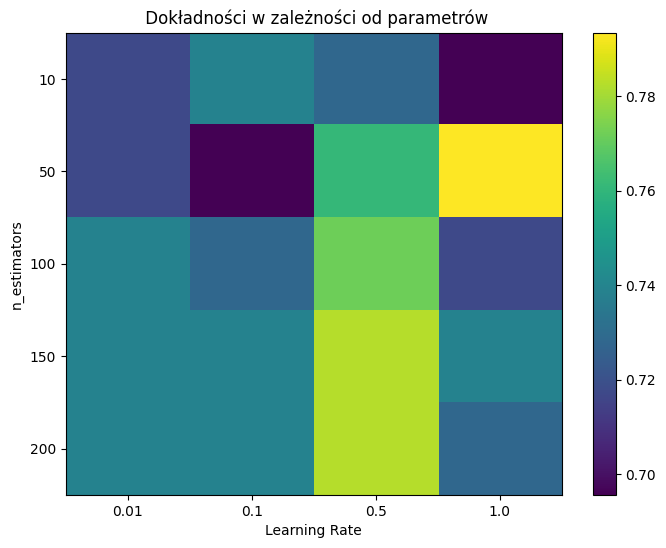

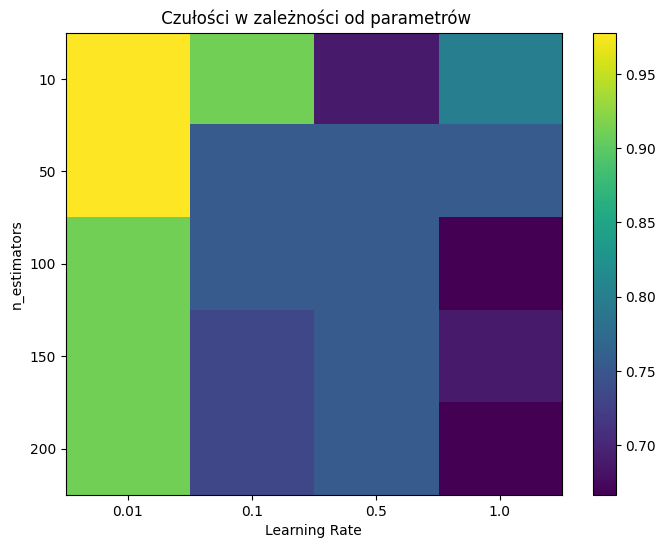

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Tworzenie heatmapy
plt.figure(figsize=(8, 6))
plt.imshow(accuracy_grid, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xticks(np.arange(len(learning_rate_values)), learning_rate_values)
plt.yticks(np.arange(len(n_estimators_values)), n_estimators_values)
plt.xlabel('Learning Rate')
plt.ylabel('n_estimators')
plt.title(' Dokładności w zależności od parametrów')
plt.show()

# Tworzenie heatmapy
plt.figure(figsize=(8, 6))
plt.imshow(recall_grid, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xticks(np.arange(len(learning_rate_values)), learning_rate_values)
plt.yticks(np.arange(len(n_estimators_values)), n_estimators_values)
plt.xlabel('Learning Rate')
plt.ylabel('n_estimators')
plt.title(' Czułości w zależności od parametrów')
plt.show()


In [20]:
# Ustawiamy warunki początkowe
second_best_recall = 0
second_best_params_recall = {}

# Iterujemy po wynikach, szukając drugiej najlepszej wartości czułości
for i, n_estimators in enumerate(n_estimators_values):
    for j, learning_rate in enumerate(learning_rate_values):
        # Jeśli aktualna kombinacja jest lepsza od dotychczasowej, ale nie lepsza od najlepszej
        if recall_grid[i][j] > second_best_recall and recall_grid[i][j] < best_recall:
            second_best_recall = recall_grid[i][j]
            second_best_params_recall = {"n_estimators": n_estimators, "learning_rate": learning_rate}

# Wyświetlamy wynik
print("Druga najlepsza czułość:")
print(second_best_params_recall)
print(f"Druga najlepsza czułość: {second_best_recall}")
print(f"Najlepsza liczba estymatorów: {second_best_params_recall['n_estimators']}")
print(f"Najlepszy learning rate: {second_best_params_recall['learning_rate']}")


Druga najlepsza czułość:
{'n_estimators': 10, 'learning_rate': 0.1}
Druga najlepsza czułość: 0.9111111111111111
Najlepsza liczba estymatorów: 10
Najlepszy learning rate: 0.1
